In [47]:
import itertools
import os
import pickle
import sys
from pathlib import Path

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.io
from skimage import exposure
from skimage.registration import phase_cross_correlation
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from config import *

In [5]:
csv_file = data_meta / "all_info.csv"

# Read dataframe containing images information
df = pd.read_csv(csv_file)

## Read masks image and corresponding intensity measurement

In [6]:
def get_masks(mask_folder):
    '''
    Function to get all mask from mask forlder
    '''
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tiff" in name:
                condition = name.split("_")[0]
                masks[condition] = masks.get(condition, {})
                filename = os.path.join(dirpath, name)
            if "cyto" in name:
                img = skimage.io.imread(filename)
                masks[condition]["cyto"] = img
            elif "nuclei" in name:
                img = skimage.io.imread(filename)
                masks[condition]["nuclei"] = img
    return masks

In [7]:
# Read mask image
masks = get_masks(data_mask)

## Create image based on intensity level of expression 

In [8]:
df_intensity = pd.read_csv(data_meta / 'measurements_intensity.csv')
df_morph = pd.read_csv(data_meta / 'measurements_morphology.csv')
markers = df_intensity.Marker.unique()

In [9]:
# Calculate total intensity from mena intensity and area size
for row in df_intensity.itertuples():
    cond = row.Condition
    i = row.Id
    total_nuclei_intensity = row.Nuclei_mean_intensity * \
        df_morph[(df_morph.Condition == cond) & (
            df_morph.Id == i)]['Nuclei_area'].item()
    total_cyto_intensity = row.Cyto_mean_intensity * \
        df_morph[(df_morph.Condition == cond) & (
            df_morph.Id == i)]['Cyto_area'].item()
    df_intensity.loc[row.Index,
                     'Nuclei_total_intensity'] = total_nuclei_intensity
    df_intensity.loc[row.Index, 'Cyto_total_intensity'] = total_cyto_intensity

We have {{len(markers)}} markers (no including DAPI and cell segmentation markers) 

In [10]:
def create_expression_img(mask_cyto, mask_nuclei, df, mean=True):
    markers = df.Marker.unique()
    imgs = []

    cell = np.zeros((mask_cyto.shape), dtype=np.uint8)
    nuclei = np.zeros((mask_cyto.shape), dtype=np.uint8)
    cyto = np.zeros((mask_cyto.shape), dtype=np.uint8)

    for label in range(1, mask_cyto.max()):
        # Check if cell has nuclei
        cell_mask = np.where(mask_cyto == label, 1, 0).astype(np.uint8)
        maski = cv2.bitwise_and(mask_nuclei, mask_nuclei, mask=cell_mask)

        # If no nuclei detected then pass
        if maski.max() == 0:
            continue

        # Link label accross cell, nuclei, cyto
        cell = np.where(mask_cyto == label, label, cell)
        nuclei = np.where(maski > 0, label, nuclei)
        maski = cv2.subtract(cell_mask, maski)
        cyto = np.where(maski > 0, label, cyto)

    for marker in markers:
        img = np.zeros((mask_cyto.shape), dtype=np.uint16)
        for label in df.Id.unique():
            row = df[(df.Id == label) & (df.Marker == marker)]
            if mean: 
                nuclei_intensity = row['Nuclei_mean_intensity'].item()
                cyto_intensity = row['Cyto_mean_intensity'].item()
            else:
                nuclei_intensity = row['Nuclei_total_intensity'].item()
                cyto_intensity = row['Cyto_total_intensity'].item()
            img = np.where(cyto == label, cyto_intensity, img)
            img = np.where(nuclei == label, nuclei_intensity, img)
        imgs.append(img)
    return imgs, markers

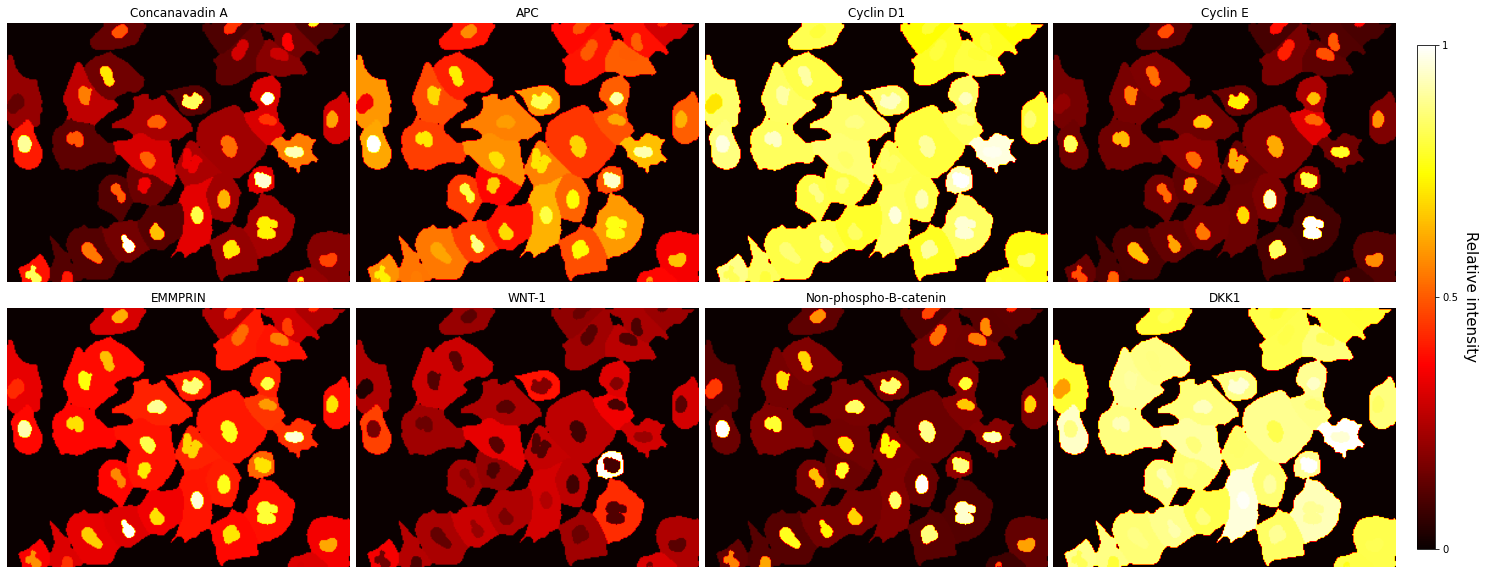

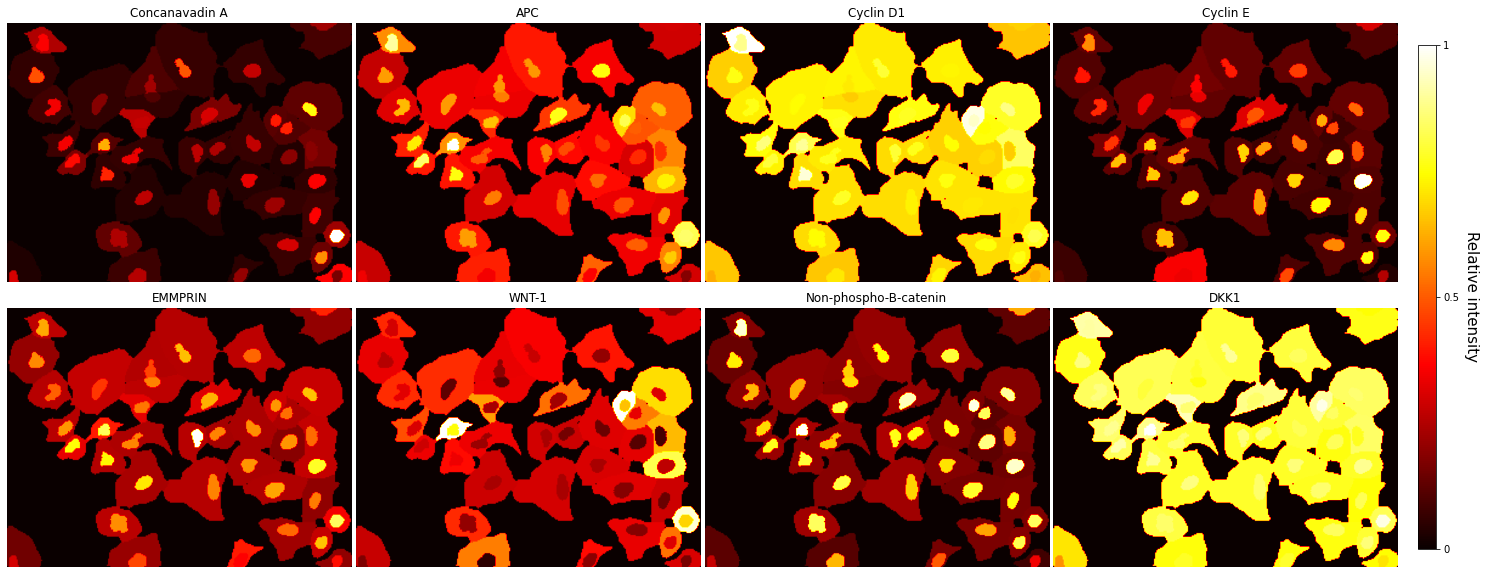

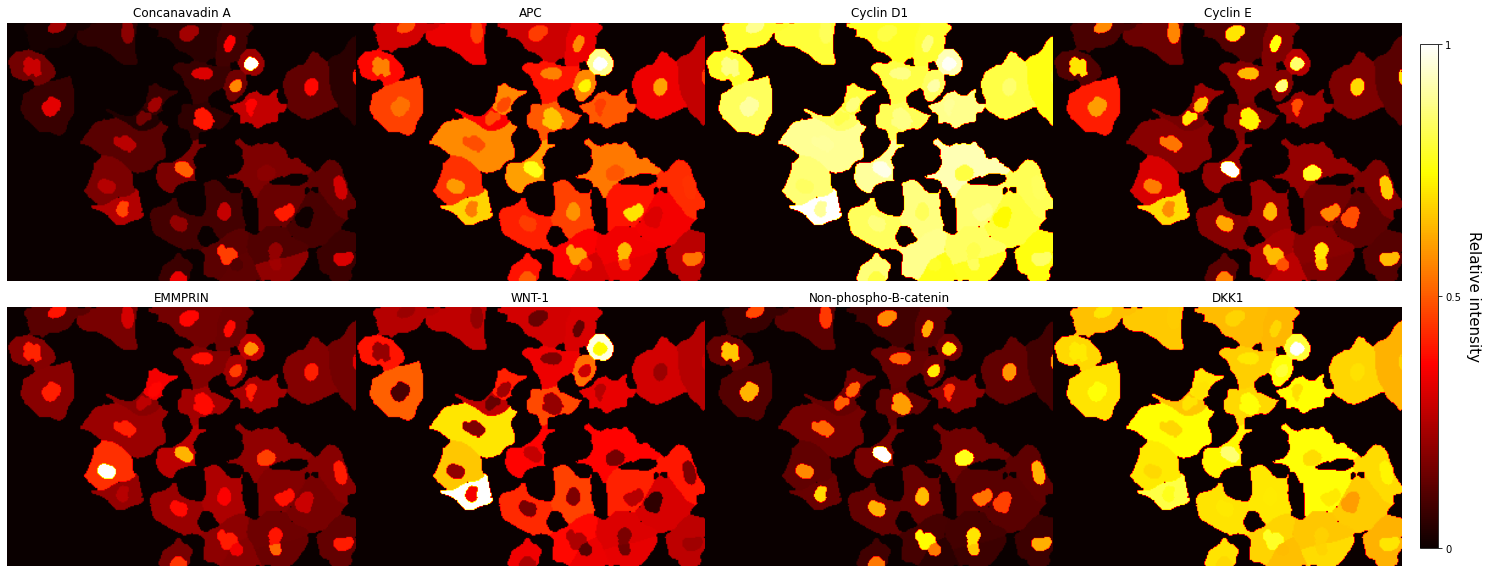

In [11]:
# Show mean intensity 

for idx, condition in enumerate(masks.keys()):
    mask_cyto = masks[condition]['cyto']
    mask_nuclei = masks[condition]['nuclei']
    df_intensity_subset = df_intensity[df_intensity.Condition == condition]
    imgs, markers = create_expression_img(
        mask_cyto, mask_nuclei, df_intensity_subset)

    fig, axs = plt.subplots(2, 4, figsize=(25, 10))
    axs = axs.flatten()
    for idx, ax in enumerate(axs):
        im = ax.imshow(imgs[idx], cmap='hot')
        ax.axis('off')
        ax.title.set_text(markers[idx])
    plt.subplots_adjust(wspace=0, hspace=0.1)

    # Add colobar
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap='hot', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, 3),
                        cax=cbar_ax)
    cbar.set_label('Relative intensity', rotation=270,
                   fontsize=15, labelpad=20)
    cbar.ax.set_yticklabels(['0', '0.5', '1'])

    # Save fig and show
    fig.savefig(condition+'_expression_level.png',
                bbox_inches='tight', dpi=100)
    plt.show()

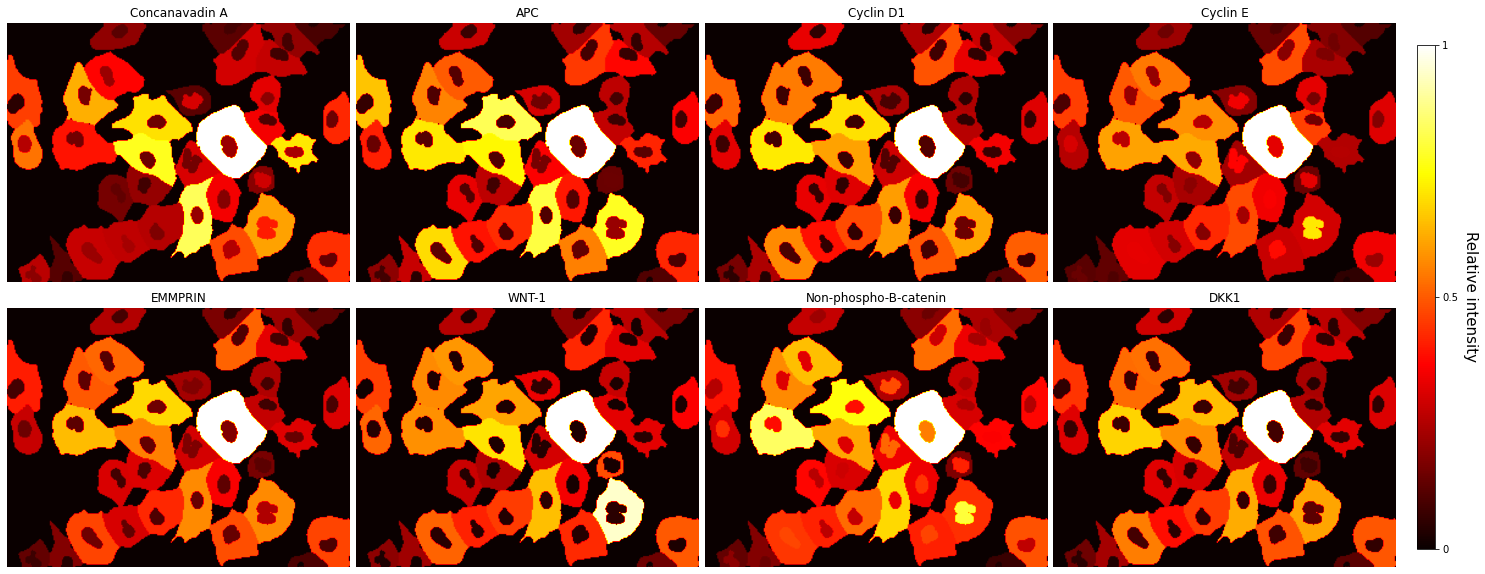

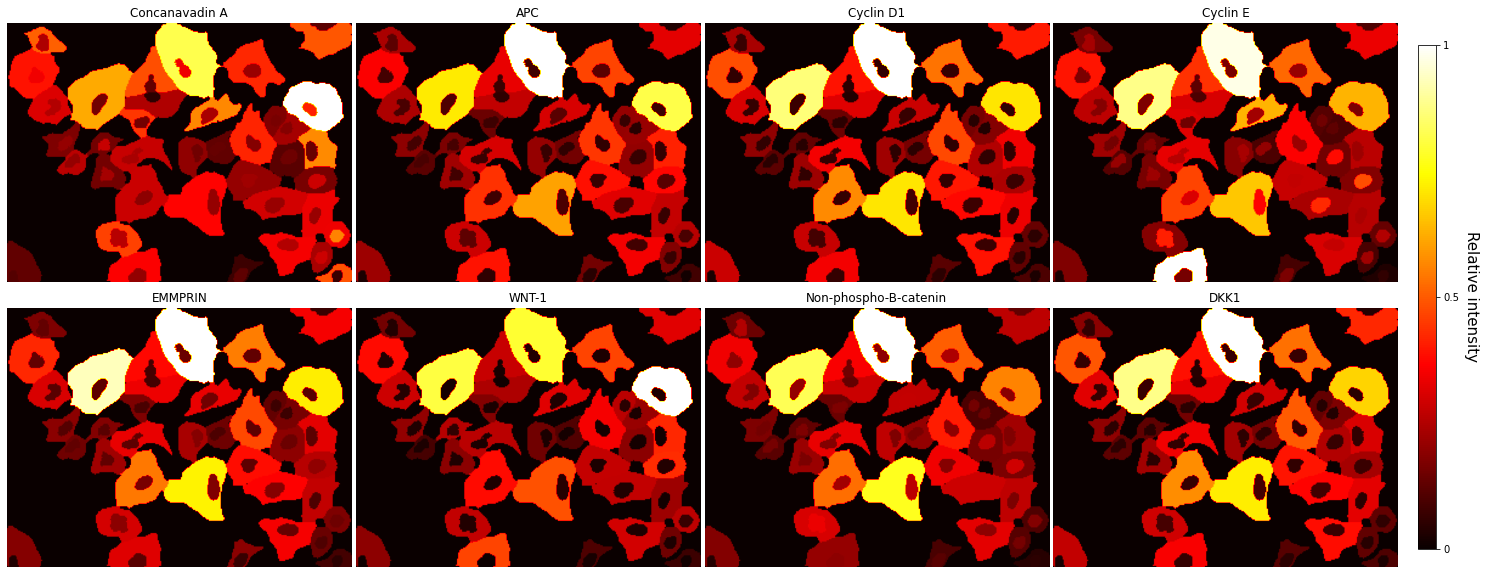

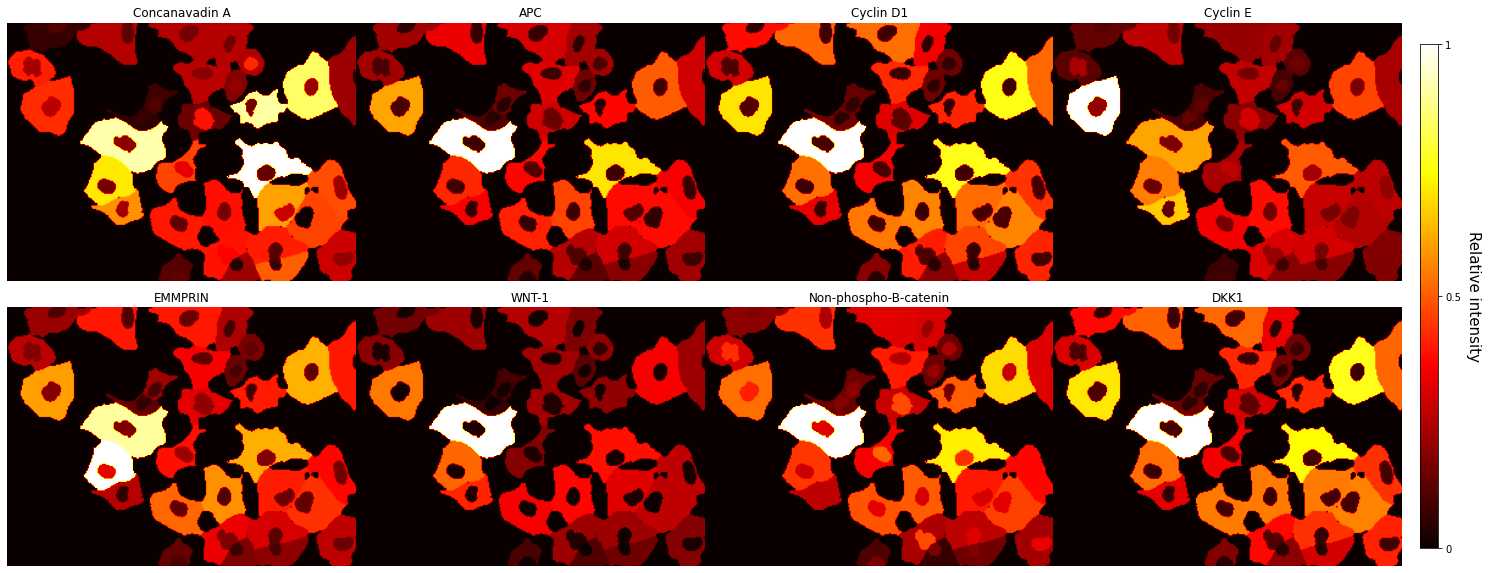

In [12]:
# Show total intensity

for idx, condition in enumerate(masks.keys()):
    mask_cyto = masks[condition]['cyto']
    mask_nuclei = masks[condition]['nuclei']
    df_intensity_subset = df_intensity[df_intensity.Condition == condition]
    imgs, markers = create_expression_img(
        mask_cyto, mask_nuclei, df_intensity_subset, mean=False)

    fig, axs = plt.subplots(2, 4, figsize=(25, 10))
    axs = axs.flatten()
    for idx, ax in enumerate(axs):
        im = ax.imshow(imgs[idx], cmap='hot')
        ax.axis('off')
        ax.title.set_text(markers[idx])
    plt.subplots_adjust(wspace=0, hspace=0.1)

    # Add colobar
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap='hot', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, 3),
                        cax=cbar_ax)
    cbar.set_label('Relative intensity', rotation=270,
                   fontsize=15, labelpad=20)
    cbar.ax.set_yticklabels(['0', '0.5', '1'])

    # Save fig and show
    fig.savefig(condition+'_expression_level_total.png',
                bbox_inches='tight', dpi=100)
    plt.show()

# Visualization

In [60]:
condition = 'Fw1' # Select the condition

# Read information 
df_cell_intensity = df_intensity.iloc[:,3:]
df_subset = df_cell_intensity[df_cell_intensity.Condition == condition]
df_subset.drop(['Condition'], axis=1, inplace=True)
df_subset.rename(columns={'Nuclei_total_intensity':'Nuclei', 'Cyto_total_intensity': 'Cyto'}, inplace=True)
display(df_subset.head())

# Pivot the dataframe
df_per_cell = df_subset.pivot(index= 'Id', columns = 'Marker', values = ['Nuclei', 'Cyto'])
display(df_per_cell.head())

# Scale the dataframe 
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(df_per_cell)
df_per_cell_scaled = pd.DataFrame(x_scaled, columns=df_per_cell.columns)

C:\Users\thu71\.conda\envs\Thomas\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\thu71\.conda\envs\Thomas\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Marker,Id,Nuclei,Cyto
0,Concanavadin A,2,8122022.0,21034732.0
1,APC,2,290177.0,3943713.0
2,Cyclin D1,2,91531.0,1640055.0
3,Cyclin E,2,864665.0,4310564.0
4,EMMPRIN,2,372170.0,4081252.0


Nuclei                                                           \
Marker        APC Concanavadin A Cyclin D1   Cyclin E      DKK1    EMMPRIN   
Id                                                                           
2        290177.0      8122022.0   91531.0   864665.0  109840.0   372170.0   
3       1433819.0     19748230.0  384471.0  3862814.0  473849.0  1574295.0   
4       2024861.0     26441315.0  468675.0  5764323.0  597692.0  2760108.0   
6       1752449.0     19386482.0  461396.0  5924703.0  565447.0  1990986.0   
7       2528818.0     23440889.0  676468.0  7160150.0  848133.0  3332775.0   

                                              Cyto                            \
Marker Non-phospho-B-catenin     WNT-1         APC Concanavadin A  Cyclin D1   
Id                                                                             
2                  1096673.0   64422.0   3943713.0     21034732.0  1640055.0   
3                  4998075.0  352912.0   6508418.0     26759007.0  2129404.0   
4                  7498015.0  367296.0   8210786.0     44008984.0  2830597.0   
6                  7216944.0  295359.0   7336736.0     45257924.0  2431291.0   
7                  9770515.0  496209.0  12874366.0     65424458.0  4193955.0   

                                                                            
Marker    Cyclin E       DKK1     EMMPRIN Non-phospho-B-catenin      WNT-1  
Id                                                                          
2        4310564.0  2146437.0   4081252.0             5885522.0  2412367.0  
3        5430361.0  2877180.0   5465039.0             6540576.0  2908351.0  
4        8440527.0  3418880.0   8008902.0             9493234.0  3685687.0  
6        7051089.0  3084279.0   6985427.0             8226800.0  3795440.0  
7       18389910.0  5462076.0  16430533.0            18144291.0  6105599.0

Text(114.0, 0.5, 'Cell Id')

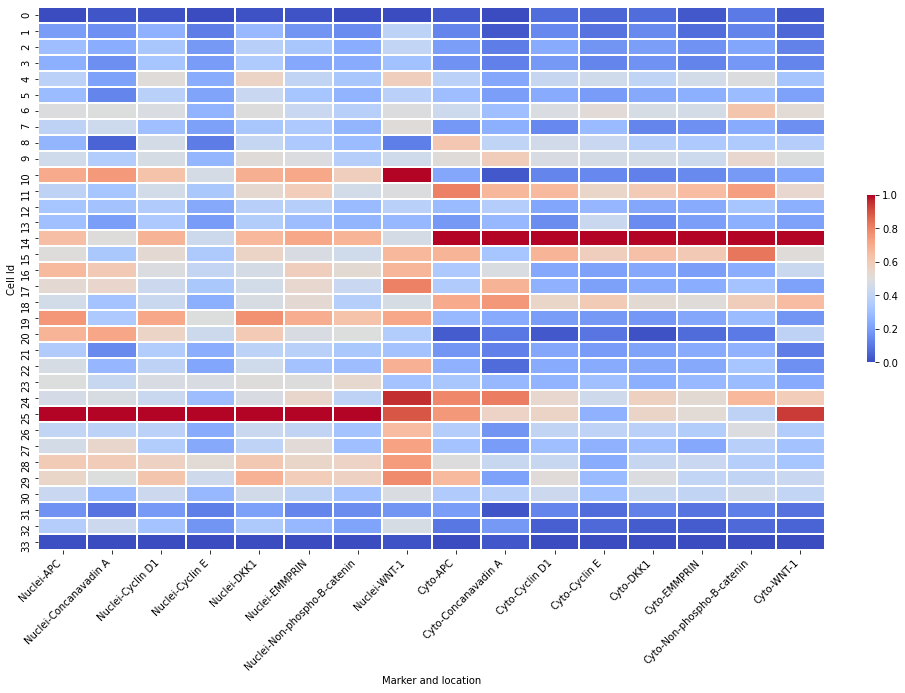

In [69]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(df_per_cell_scaled,
                 cbar_kws={'fraction' : 0.01},
                 cmap='coolwarm',
                 linewidth=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel('Marker and location')
ax.set_ylabel('Cell Id')